In [ ]:
# Install required libraries
!pip install statsmodels
!pip install pmdarima

In [ ]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Import time series modeling tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Import evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import date formatter for plots
import matplotlib.dates as mdates

In [ ]:
# Load CSV file from a Google Drive view URL and skip malformed lines
def load_gdrive_csv(view_url):
    file_id = view_url.split('/')[-2]
    url = f'https://drive.google.com/uc?id={file_id}'
    return pd.read_csv(url, on_bad_lines='skip')

train_df = load_gdrive_csv(
    'https://drive.google.com/file/d/1UlnpfTD-53TzUvDqmFMfN03hUXtGquFr/view?usp=drive_link')
test_df = load_gdrive_csv(
    'https://drive.google.com/file/d/1FMeGjhigcHdtBmIclxEDUaiBRUuf5H9_/view?usp=drive_link')

target = 'Price'

In [ ]:
# Define the endogenous variable (target) and exogenous variables (external regressors)
endog = train_df['Price']
exog = train_df[['Open', 'High', 'Low', 'Change %']]

# Automatically determine the optimal (p,d,q) parameters for ARIMAX model using BIC
model = auto_arima(endog, exogenous=exog, seasonal=False,
                   stepwise=True, suppress_warnings=True,
                   information_criterion='bic', max_p=5, max_q=5)

print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3164
Model:               SARIMAX(0, 1, 0)   Log Likelihood               13019.215
Date:                Sun, 25 May 2025   AIC                         -26036.430
Time:                        04:57:01   BIC                         -26030.371
Sample:                             0   HQIC                        -26034.256
                               - 3164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.557e-05   1.21e-07    128.489      0.000    1.53e-05    1.58e-05
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):             47399.68
Prob(Q):                              0.30   Pr

In [ ]:
# Extract optimal ARIMA parameters from auto_arima model and define forecast horizon
p, d, q = model.order
forecast_steps = 30

# Convert 'Date' to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [ ]:
# Prepare endog and exog for training and testing
train_endog = train_df['Price'].tolist()
train_exog = train_df[['Open', 'High', 'Low', 'Change %']].values.tolist()
test_exog = test_df[['Open', 'High', 'Low', 'Change %']].values

# Initialize prediction list and history buffers
predictions_test = []
history_endog = train_endog.copy()
history_exog = train_exog.copy()

# Recursively forecast test data step-by-step using updated history
for i in range(len(test_df)):
    next_exog = test_exog[i].reshape(1, -1)

    model = SARIMAX(history_endog, exog=history_exog, order=(p, d, q),
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False, maxiter=50, method='powell')

    next_pred = model_fit.forecast(steps=1, exog=next_exog)[0]
    predictions_test.append(next_pred)

    history_endog.append(next_pred)
    history_exog.append(next_exog.flatten().tolist())

In [ ]:
# Get true target values from test set
true_values = test_df['Price'].values

# Compute evaluation metrics: MAE, MSE, RMSE, MAPE, R²
mae = mean_absolute_error(true_values, predictions_test)
mse = mean_squared_error(true_values, predictions_test)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((true_values - predictions_test) / true_values)) * 100
r2 = r2_score(true_values, predictions_test)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 0.0041
MSE: 0.0000
RMSE: 0.0046
MAPE: 0.51%
R²: 0.9778


In [ ]:
# Prepare exog data for next 30 days (based on last 60 rows)
future_exog = pd.concat([train_df, test_df], ignore_index=True).iloc[-30:][['Open', 'High', 'Low', 'Change %']].values

# Recursively forecast next 30 days using exog data
predictions_future = []

for i in range(forecast_steps):
    next_exog = future_exog[i].reshape(1, -1)

    model = SARIMAX(history_endog, exog=history_exog, order=(p, d, q),
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False, maxiter=50, method='powell')

    next_pred = model_fit.forecast(steps=1, exog=next_exog)[0]
    predictions_future.append(next_pred)

    history_endog.append(next_pred)
    history_exog.append(next_exog.flatten().tolist())

# Generate date range for next 30 days
future_dates = pd.date_range(start=test_df['Date'].max() + pd.Timedelta(days=1),
                             periods=forecast_steps, freq='D')

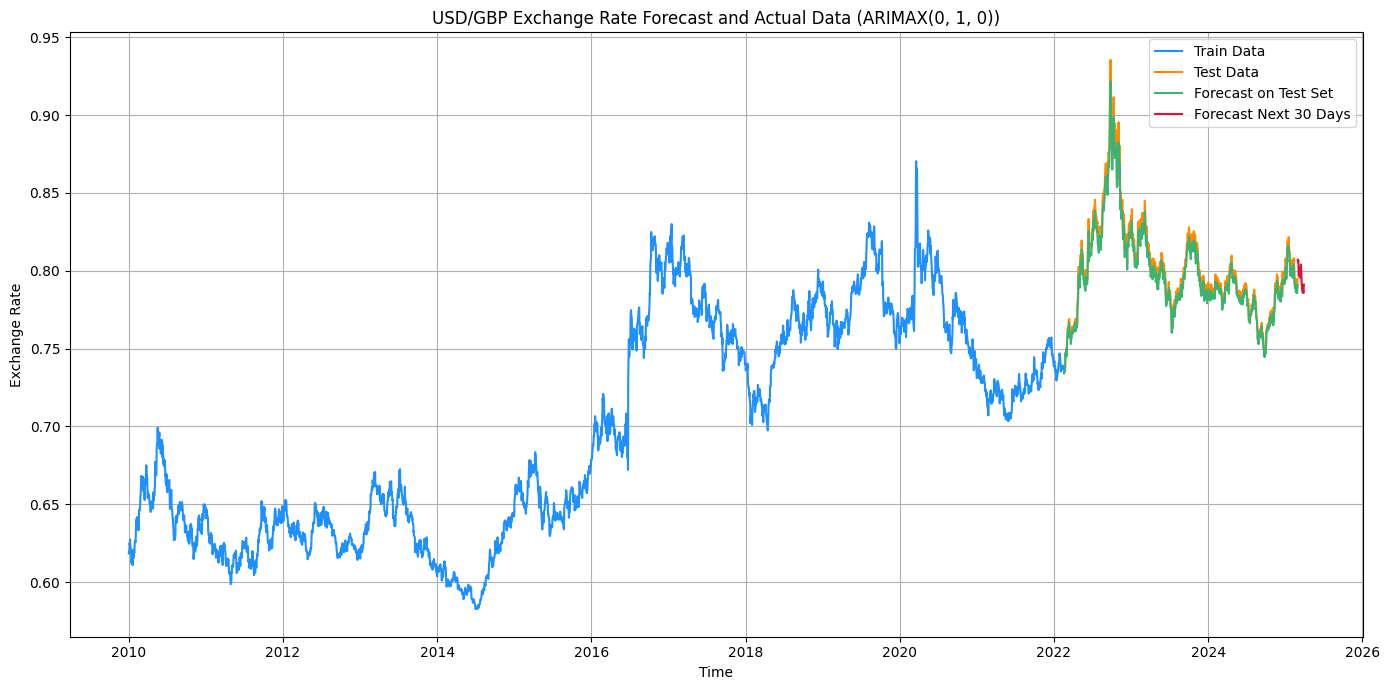

In [ ]:
# Plot data
plt.figure(figsize=(14, 7))
plt.plot(train_df['Date'], train_df['Price'], label='Train Data', color='dodgerblue')
plt.plot(test_df['Date'], test_df['Price'], label='Test Data', color='darkorange')
plt.plot(test_df['Date'], predictions_test, label='Forecast on Test Set', color='mediumseagreen')
plt.plot(future_dates, predictions_future, label='Forecast Next 30 Days', color='crimson')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.xticks(rotation=0)

order = model.order
plt.title(f'USD/GBP Exchange Rate Forecast and Actual Data (ARIMAX{order})')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

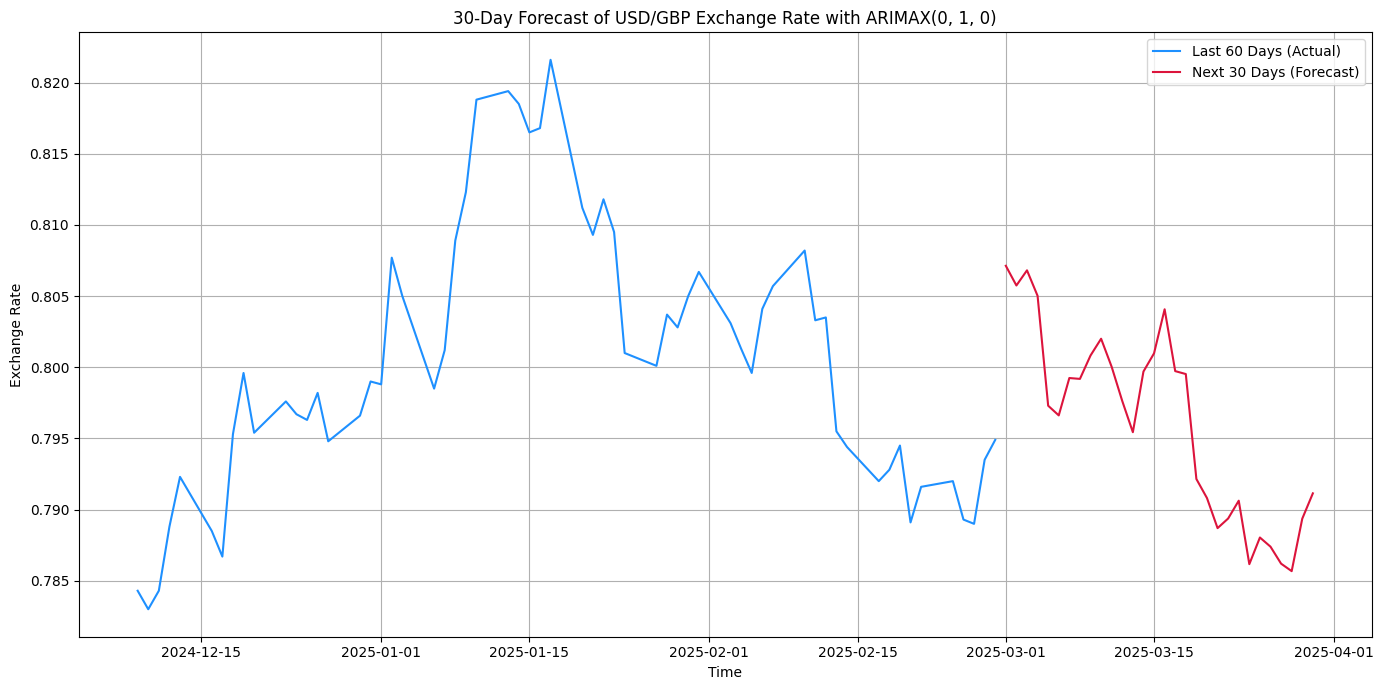

In [ ]:
# Get last 60 actual days (Price and Date)
full_price = pd.concat([train_df['Price'], test_df['Price']], ignore_index=True)
full_dates = pd.concat([train_df['Date'], test_df['Date']], ignore_index=True)
last_60 = full_price.iloc[-60:].values
x_dates_60 = pd.to_datetime(full_dates.iloc[-60:])

# Generate future 30-day date range for forecast
x_dates_future = pd.date_range(start=x_dates_60.iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(x_dates_60, last_60, label='Last 60 Days (Actual)', color='dodgerblue')
plt.plot(x_dates_future, predictions_future, label='Next 30 Days (Forecast)', color='crimson')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

plt.title(f'30-Day Forecast of USD/GBP Exchange Rate with ARIMAX{order}')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()